# 17장 객체 검출 (Two-stage object detection)
- RCNN, Fast/Faster RCNN, Masked RCNN

* "부록3 매트플롯립 입문"에서 한글 폰트를 올바르게 출력하기 위한 설치 방법을 설명했다. 설치 방법은 다음과 같다.

In [ ]:
!sudo apt-get install -y fonts-nanum* | tail -n 1
!sudo fc-cache -fv
!rm -rf ~/.cache/matplotlib

In [ ]:
# 필요 라이브러리 설치

!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1


* 모든 설치가 끝나면 한글 폰트를 바르게 출력하기 위해 **[런타임]** -> **[런타임 다시시작]**을 클릭한 다음, 아래 셀부터 코드를 실행해 주십시오.

In [1]:
# 라이브러리 임포트

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# 폰트 관련 용도
import matplotlib.font_manager as fm

# Colab, Linux
# 나눔 고딕 폰트의 경로 명시
path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=path, size=10).get_name()

# Window 
# font_name = "NanumBarunGothic"

# Mac
# font_name = "AppleGothic"

In [2]:
# warning 표시 끄기
import warnings
warnings.simplefilter('ignore')

import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
# 폰트 관련 용도
import matplotlib.font_manager as fm

import torch
from torchvision.io import read_image
from torchvision import models, datasets, transforms
from torchinfo import summary
from torchviz import make_dot
from torch import nn, optim
import torchvision.transforms.functional as F

In [3]:
# 기본 폰트 설정
plt.rcParams['font.family'] = font_name  # window font

# 기본 폰트 사이즈 변경
plt.rcParams['font.size'] = 14

# 기본 그래프 사이즈 변경
plt.rcParams['figure.figsize'] = (6,6)

# 기본 그리드 표시
# 필요에 따라 설정할 때는, plt.grid()
plt.rcParams['axes.grid'] = True
plt.rcParams["grid.linestyle"] = ":"

# 마이너스 기호 정상 출력
plt.rcParams['axes.unicode_minus'] = False

# 넘파이 부동소수점 자릿수 표시
np.set_printoptions(suppress=True, precision=4)

In [4]:
# GPU 디바이스 할당

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Faster R-CNN 사용하기

In [ ]:
''' 
The model builder above accepts the following values as the weights parameter. 
FasterRCNN_ResNet50_FPN_Weights.DEFAULT is equivalent to FasterRCNN_ResNet50_FPN_Weights.COCO_V1. 
You can also use strings, e.g. weights='DEFAULT' or weights='COCO_V1'.

The inference transforms are available at FasterRCNN_ResNet50_FPN_Weights.COCO_V1.transforms 
and perform the following preprocessing operations: 
Accepts PIL.Image, batched (B, C, H, W) and single (C, H, W) image torch.Tensor objects. 
The images are rescaled to [0.0, 1.0].
'''

In [8]:
## Pretrained object detection model list
dir(models.detection)

['FCOS',
 'FCOS_ResNet50_FPN_Weights',
 'FasterRCNN',
 'FasterRCNN_MobileNet_V3_Large_320_FPN_Weights',
 'FasterRCNN_MobileNet_V3_Large_FPN_Weights',
 'FasterRCNN_ResNet50_FPN_V2_Weights',
 'FasterRCNN_ResNet50_FPN_Weights',
 'KeypointRCNN',
 'KeypointRCNN_ResNet50_FPN_Weights',
 'MaskRCNN',
 'MaskRCNN_ResNet50_FPN_V2_Weights',
 'MaskRCNN_ResNet50_FPN_Weights',
 'RetinaNet',
 'RetinaNet_ResNet50_FPN_V2_Weights',
 'RetinaNet_ResNet50_FPN_Weights',
 'SSD300_VGG16_Weights',
 'SSDLite320_MobileNet_V3_Large_Weights',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_utils',
 'anchor_utils',
 'backbone_utils',
 'faster_rcnn',
 'fasterrcnn_mobilenet_v3_large_320_fpn',
 'fasterrcnn_mobilenet_v3_large_fpn',
 'fasterrcnn_resnet50_fpn',
 'fasterrcnn_resnet50_fpn_v2',
 'fcos',
 'fcos_resnet50_fpn',
 'generalized_rcnn',
 'image_list',
 'keypoint_rcnn',
 'keypointrcnn_resnet50_fpn',
 'mask_rcnn',
 'maskrcnn_resnet50_fpn'

### 모델 불러 오기

In [14]:
weights= models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT
fasterRCNN = models.detection.fasterrcnn_resnet50_fpn(weights=weights)

### 모델 구조 확인

In [15]:
print(fasterRCNN) # PyTorch의 torchvision 라이브러리는 RGB 형식을 사용

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [17]:
fasterRCNN = fasterRCNN.to(device)

### 추론 하기

In [22]:
## 결과 형식 확인
fasterRCNN.eval() ## 추론 모드드

x = [torch.rand(3, 300, 400).to(device), 
     torch.rand(3, 500, 400).to(device)]


Faster RCNN outputs = 



[{'boxes': tensor([], device='cuda:0', size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], device='cuda:0', dtype=torch.int64),
  'scores': tensor([], device='cuda:0', grad_fn=<IndexBackward0>)},
 {'boxes': tensor([], device='cuda:0', size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], device='cuda:0', dtype=torch.int64),
  'scores': tensor([], device='cuda:0', grad_fn=<IndexBackward0>)}]

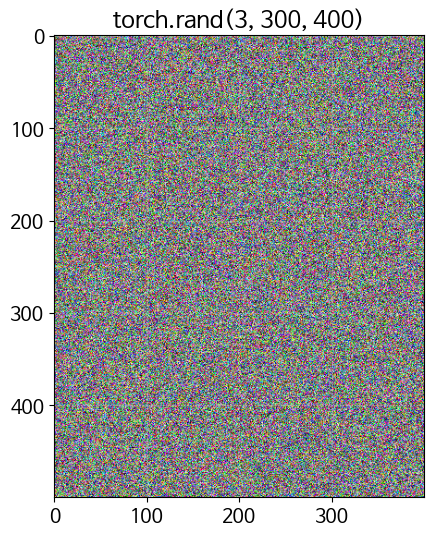

In [24]:
predictions = fasterRCNN(x)
print("Faster RCNN outputs = \n")
display(predictions)

plt.imshow(x[1].cpu().permute(1, 2, 0))
plt.title("torch.rand(3, 300, 400)")
plt.show()

In [26]:
# Wrapper model for compatibility with summary
# summary(fasterRCNN, input_size= (3, 226, 226)) # error

class FasterRCNNWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        # Convert the 4D tensor into a list of 3D tensors
        x = [img for img in x]
        # Get the predictions from the model
        output = self.model(x)
        # Return a placeholder tensor for torchinfo (e.g., batch of dummy boxes)
        
        return output

# Wrap the model
wrapped_model = FasterRCNNWrapper(fasterRCNN)
# Generate the model summary
summary(wrapped_model, input_size=(2, 3, 226, 226))  #  cpu to cuda
# print("1", fasterRCNN.backbone.body.conv1.weight.device)

Layer (type:depth-idx)                                       Output Shape              Param #
FasterRCNNWrapper                                            [0, 4]                    --
├─FasterRCNN: 1-1                                            [0, 4]                    --
│    └─GeneralizedRCNNTransform: 2-1                         [2, 3, 800, 800]          --
│    └─BackboneWithFPN: 2-2                                  [2, 256, 13, 13]          --
│    │    └─IntermediateLayerGetter: 3-1                     [2, 2048, 25, 25]         23,454,912
│    │    └─FeaturePyramidNetwork: 3-2                       [2, 256, 13, 13]          3,344,384
│    └─RegionProposalNetwork: 2-3                            [1000, 4]                 --
│    │    └─RPNHead: 3-3                                     [2, 3, 200, 200]          593,935
│    │    └─AnchorGenerator: 3-4                             [159882, 4]               --
│    └─RoIHeads: 2-4                                         [0, 4]        

### COCO labels 확인

In [27]:
coco_labels_list = weights.meta["categories"]
print("COCO v1 dataset  = ", len(coco_labels_list)) # 80 + dummy 11
display(coco_labels_list)

COCO v1 dataset  =  91


['__background__',
 'person',
 'bicycle',
 'car',
 'motorcycle',
 'airplane',
 'bus',
 'train',
 'truck',
 'boat',
 'traffic light',
 'fire hydrant',
 'N/A',
 'stop sign',
 'parking meter',
 'bench',
 'bird',
 'cat',
 'dog',
 'horse',
 'sheep',
 'cow',
 'elephant',
 'bear',
 'zebra',
 'giraffe',
 'N/A',
 'backpack',
 'umbrella',
 'N/A',
 'N/A',
 'handbag',
 'tie',
 'suitcase',
 'frisbee',
 'skis',
 'snowboard',
 'sports ball',
 'kite',
 'baseball bat',
 'baseball glove',
 'skateboard',
 'surfboard',
 'tennis racket',
 'bottle',
 'N/A',
 'wine glass',
 'cup',
 'fork',
 'knife',
 'spoon',
 'bowl',
 'banana',
 'apple',
 'sandwich',
 'orange',
 'broccoli',
 'carrot',
 'hot dog',
 'pizza',
 'donut',
 'cake',
 'chair',
 'couch',
 'potted plant',
 'bed',
 'N/A',
 'dining table',
 'N/A',
 'N/A',
 'toilet',
 'N/A',
 'tv',
 'laptop',
 'mouse',
 'remote',
 'keyboard',
 'cell phone',
 'microwave',
 'oven',
 'toaster',
 'sink',
 'refrigerator',
 'N/A',
 'book',
 'clock',
 'vase',
 'scissors',
 'ted

### 폴더 내 영상 읽기

In [31]:
data_dir = "./figure"

img_path = os.path.join(data_dir, "dog.jpg")
img = read_image(img_path).to(device)

print('img type = ', type(img))
print("image shape = ", img.shape)

img type =  <class 'torch.Tensor'>
image shape =  torch.Size([3, 576, 768])


### 영상 전처리

In [32]:
fasterRCNN = fasterRCNN.to(device)
preprocess = weights.transforms() # 학습 자료에 맞에 조정
fasterRCNN

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [36]:
batch_img = preprocess(img) # 
batch_img.shape

torch.Size([3, 576, 768])

In [37]:
batch_img = batch_img.unsqueeze(0)
# batch_img = batch_img.to(device)

### 모델 예측

In [41]:
import time
fasterRCNN.eval()

start = time.time()
pred = fasterRCNN(batch_img)
stop = time.time()
print(f"estimation time = {(stop - start)*1000:.3f}ms")

pred

[{'boxes': tensor([[130.3126, 225.0357, 319.0403, 534.0589],
          [163.7504, 104.9969, 570.4412, 448.7537],
          [127.9439, 139.2940, 277.1543, 382.7612],
          [471.6621,  79.2776, 680.4760, 169.9647],
          [129.2778, 231.7216, 218.7447, 381.2831],
          [467.3390,  83.1568, 678.7368, 167.9611],
          [711.6593,  29.0584, 760.4049, 244.5217],
          [132.6494, 122.8677, 409.6773, 420.0911],
          [676.1831,  98.1239, 718.5799, 155.4015],
          [126.9611, 132.6783, 436.8705, 404.2952],
          [ 58.3749,  85.2088, 103.5193, 127.3281],
          [599.1298, 105.8067, 619.8306, 122.4434],
          [ 55.8846,  86.5438,  84.3360, 135.6524],
          [134.2069, 215.0720, 322.5725, 536.2981],
          [ 58.4227,  79.5715, 106.2005, 127.5270],
          [600.6806, 107.6764, 613.7610, 120.5343],
          [718.4550,  28.6718, 766.1320, 269.9488],
          [124.7195, 138.1096, 591.1942, 512.2091],
          [677.8379,  32.0160, 744.9001, 163.6230],
   

### 분류 및 Bounding box 확인하기

In [42]:
pred_dict = pred[0]
print("pred_dict = \n", pred_dict)
print("keys = ", pred_dict.keys())
print("labels = ", pred_dict["labels"])
print("scores = ", pred_dict["scores"])

pred_dict = 
 {'boxes': tensor([[130.3126, 225.0357, 319.0403, 534.0589],
        [163.7504, 104.9969, 570.4412, 448.7537],
        [127.9439, 139.2940, 277.1543, 382.7612],
        [471.6621,  79.2776, 680.4760, 169.9647],
        [129.2778, 231.7216, 218.7447, 381.2831],
        [467.3390,  83.1568, 678.7368, 167.9611],
        [711.6593,  29.0584, 760.4049, 244.5217],
        [132.6494, 122.8677, 409.6773, 420.0911],
        [676.1831,  98.1239, 718.5799, 155.4015],
        [126.9611, 132.6783, 436.8705, 404.2952],
        [ 58.3749,  85.2088, 103.5193, 127.3281],
        [599.1298, 105.8067, 619.8306, 122.4434],
        [ 55.8846,  86.5438,  84.3360, 135.6524],
        [134.2069, 215.0720, 322.5725, 536.2981],
        [ 58.4227,  79.5715, 106.2005, 127.5270],
        [600.6806, 107.6764, 613.7610, 120.5343],
        [718.4550,  28.6718, 766.1320, 269.9488],
        [124.7195, 138.1096, 591.1942, 512.2091],
        [677.8379,  32.0160, 744.9001, 163.6230],
        [ 69.7168,  86.961

### Bounding box 그리기

In [43]:
threshold = 0.7
indices = pred_dict['scores'] >= threshold
print("indices = ", indices)
pred_boxes = pred_dict['boxes'][indices]
pred_labels = pred_dict['labels'][indices]
pred_scores = pred_dict['scores'][indices]

print("pred_boxes = \n", pred_boxes)
print("pred_labels = \n", pred_labels)
print("pred_scores = \n", pred_scores)


indices =  tensor([ True,  True,  True,  True, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False], device='cuda:0')
pred_boxes = 
 tensor([[130.3126, 225.0357, 319.0403, 534.0589],
        [163.7504, 104.9969, 570.4412, 448.7537],
        [127.9439, 139.2940, 277.1543, 382.7612],
        [471.6621,  79.2776, 680.4760, 169.9647]], device='cuda:0',
       grad_fn=<IndexBackward0>)
pred_labels = 
 tensor([18,  2,  2,  3], device='cuda:0')
pred_scores = 
 tensor([0.9960, 0.9841, 0.8145, 0.7615], device='cuda:0',
       grad_fn=<IndexBackward0>)


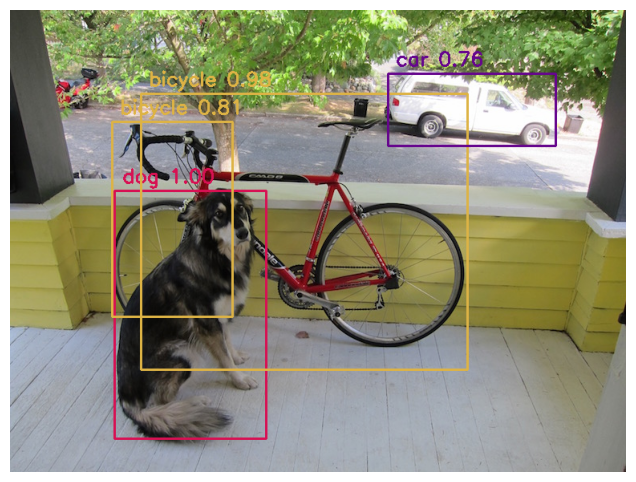

In [44]:
import random

image = img.permute(1, 2, 0).cpu().numpy()
color_array = [[random.randint(0, 255) for _ in range(3)] for _ in range(91)]

for i in range(len(pred_boxes)):
    x_min = int(pred_boxes[i][0])
    y_min = int(pred_boxes[i][1])
    x_max = int(pred_boxes[i][2])
    y_max = int(pred_boxes[i][3])

    color = color_array[pred_labels[i]]

    cv2.rectangle(image,
                      pt1=(x_min, y_min),
                      pt2=(x_max, y_max),
                      color=color,
                      thickness=2)
    
    cv2.putText(image,
                    text=coco_labels_list[pred_labels[i]] + ' {:.2f}'.format(pred_scores[i].item()),
                    org=(x_min + 10, y_min - 10),  # must be int
                    fontFace=0,
                    fontScale=0.8,
                    color=color, thickness = 2)

plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.grid(None)
plt.axis("off")
plt.show()

# 의미적 분할 (Semantic segmentation)


In [ ]:
# plt.rcParams["savefig.bbox"] = 'tight'
# def show(imgs):
#     # if not isinstance(imgs, list):
#     #     imgs = [imgs]
#     fig, axs = plt.subplots(ncols=len(imgs), figsize = (12, 6),  squeeze=False) # returned as a 2D array even if there is only one row or column of subplots.

#     for i, img in enumerate(imgs):
#         img = img.detach()
#         img = F.to_pil_image(img) # permute dimension
#         axs[0, i].imshow(np.asarray(img))
#         # axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
#         axs[0, i].axis("off")

### Draw 함수 정의

In [8]:

# plt.rcParams["savefig.bbox"] = 'tight' # 모든 저장 시 여백 최소화
def show(imgs : list):
    if not isinstance(imgs, list):
        imgs = [imgs]
    
    fig, axs = plt.subplots(ncols=len(imgs), figsize = (12, 6),  squeeze=False) # returned as a 2D array even if there is only one row or column of subplots.

    for i, img in enumerate(imgs):
        # img = img.detach().permute(1, 2, 0)
        img = F.to_pil_image(img) # permute dimension
        axs[0, i].imshow(img)
        # axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        axs[0, i].axis("off")

### 이미지 list 만들기

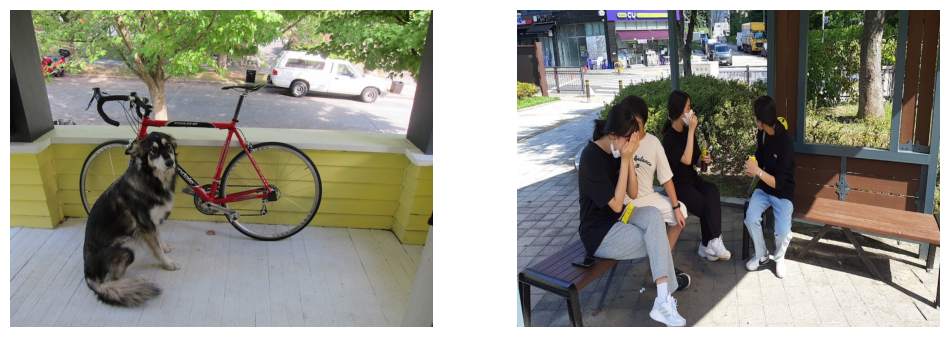

In [9]:
from torchvision.utils import make_grid
from torchvision.io import read_image

data_dir = "./figure"

img1 = read_image(os.path.join(data_dir, "dog.jpg"))
img2 = read_image(os.path.join(data_dir, "peoples.jpg"))

img_list = [img1, img2]
show(img_list)

### Bounding box 그리기 함수

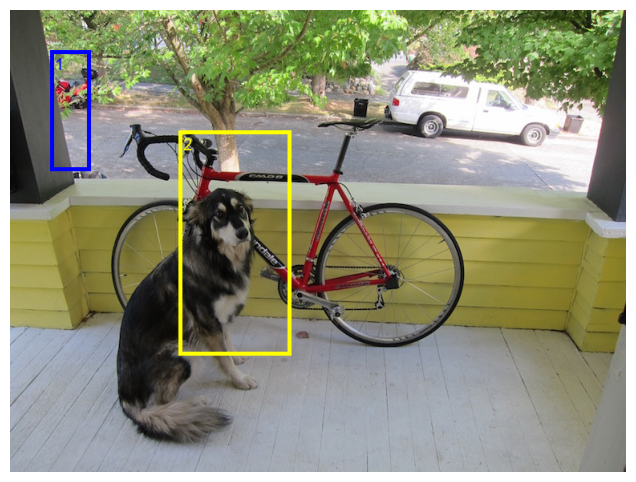

In [10]:
# draw_bounding_boxes(image:Tensor, boxes:Tensor, labels:List[str], colors:List[str] , width:int=1)
# find /usr/share/fonts -name "*.ttf"

from torchvision.utils import draw_bounding_boxes
from PIL import Image

pred_boxes = torch.tensor([[50, 50, 100, 200], 
                           [210, 150, 350, 430]], dtype=torch.float) #  (xmin, ymin, xmax, ymax) format.
labels = ["1", "2"]
colors = ["blue", "yellow"]
result = draw_bounding_boxes(img1, pred_boxes, labels, colors=colors, width=5, 
                            #  font="C:\\Windows\\Fonts\\arial.ttf", # window case
                            font = font_name,
                             font_size= 20) # boxes.shape torch.Size([2, 4])
show(result)

In [11]:
weights= models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT
fasterRCNN = models.detection.fasterrcnn_resnet50_fpn(weights=weights).to(device)

In [12]:

transforms = weights.transforms()
images = [transforms(d).to(device) for d in img_list]

In [13]:

fasterRCNN.eval()
outputs = fasterRCNN(images)

In [14]:
print(outputs[0]["labels"])
print(outputs[0]["scores"])
print(outputs[0]["boxes"])
len(outputs)

tensor([18,  2,  2,  3,  2,  8, 64,  2, 64, 15, 64,  1, 64, 17,  4,  1, 72, 15,
        64,  4, 15, 62,  1, 31, 62])
tensor([0.9960, 0.9841, 0.8145, 0.7615, 0.6086, 0.5446, 0.3389, 0.3327, 0.2993,
        0.2790, 0.2676, 0.2547, 0.2136, 0.2028, 0.2025, 0.1514, 0.1428, 0.1047,
        0.0956, 0.0849, 0.0809, 0.0671, 0.0607, 0.0524, 0.0516],
       grad_fn=<IndexBackward0>)
tensor([[130.3126, 225.0357, 319.0403, 534.0589],
        [163.7504, 104.9968, 570.4410, 448.7537],
        [127.9440, 139.2940, 277.1543, 382.7611],
        [471.6621,  79.2776, 680.4758, 169.9647],
        [129.2778, 231.7217, 218.7447, 381.2831],
        [467.3391,  83.1568, 678.7368, 167.9612],
        [711.6593,  29.0584, 760.4049, 244.5217],
        [132.6494, 122.8677, 409.6776, 420.0912],
        [676.1831,  98.1239, 718.5799, 155.4015],
        [126.9611, 132.6782, 436.8708, 404.2953],
        [ 58.3749,  85.2088, 103.5193, 127.3281],
        [599.1298, 105.8067, 619.8306, 122.4434],
        [ 55.8846,  86.54

2

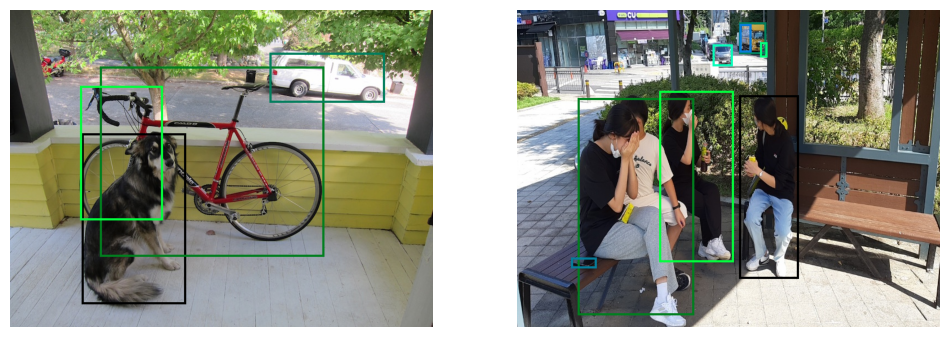

In [15]:
score_threshold = .7
dogs_with_boxes = [
    draw_bounding_boxes(img, boxes=output['boxes'][output['scores'] > score_threshold], width=4)
    for img, output in zip(img_list, outputs)]
show(dogs_with_boxes)

## Semantic Segmentation 모델 불러 오기

In [16]:
dir(models.segmentation)

['DeepLabV3',
 'DeepLabV3_MobileNet_V3_Large_Weights',
 'DeepLabV3_ResNet101_Weights',
 'DeepLabV3_ResNet50_Weights',
 'FCN',
 'FCN_ResNet101_Weights',
 'FCN_ResNet50_Weights',
 'LRASPP',
 'LRASPP_MobileNet_V3_Large_Weights',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_utils',
 'deeplabv3',
 'deeplabv3_mobilenet_v3_large',
 'deeplabv3_resnet101',
 'deeplabv3_resnet50',
 'fcn',
 'fcn_resnet101',
 'fcn_resnet50',
 'lraspp',
 'lraspp_mobilenet_v3_large']

In [17]:
# from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights

weights = models.segmentation.FCN_ResNet50_Weights.DEFAULT
model = models.segmentation.fcn_resnet50(weights=weights, progress=True).to(device)


In [18]:
transforms = weights.transforms(resize_size = None)
print(transforms)

SemanticSegmentation(
    resize_size=None
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


### 모델 추론

In [19]:
batch = torch.stack([transforms(d) for d in img_list]).to(device)
batch.shape

torch.Size([2, 3, 576, 768])

In [20]:
model.eval()
output = model(batch)['out'] # [batch_size, num_classes, height, width]
# print(output.shape, output.min().item(), output.max().item()) # logits
print(output.shape) # logits


torch.Size([2, 21, 576, 768])


### class dictionary 만들기

In [21]:
sem_class_to_idx = {cls: idx for idx, cls in enumerate(weights.meta["categories"])}
sem_class_to_idx

{'__background__': 0,
 'aeroplane': 1,
 'bicycle': 2,
 'bird': 3,
 'boat': 4,
 'bottle': 5,
 'bus': 6,
 'car': 7,
 'cat': 8,
 'chair': 9,
 'cow': 10,
 'diningtable': 11,
 'dog': 12,
 'horse': 13,
 'motorbike': 14,
 'person': 15,
 'pottedplant': 16,
 'sheep': 17,
 'sofa': 18,
 'train': 19,
 'tvmonitor': 20}

### Class score map

In [22]:
normalized_masks = torch.softmax(output, dim=1) # torch.Size([2, 21, 576, 768]), [batch_size, num_classes, height, width]
normalized_masks

tensor([[[[9.9247e-01, 9.9247e-01, 9.9247e-01,  ..., 9.9076e-01,
           9.9076e-01, 9.9076e-01],
          [9.9247e-01, 9.9247e-01, 9.9247e-01,  ..., 9.9076e-01,
           9.9076e-01, 9.9076e-01],
          [9.9247e-01, 9.9247e-01, 9.9247e-01,  ..., 9.9076e-01,
           9.9076e-01, 9.9076e-01],
          ...,
          [9.9625e-01, 9.9625e-01, 9.9625e-01,  ..., 9.5328e-01,
           9.5328e-01, 9.5328e-01],
          [9.9625e-01, 9.9625e-01, 9.9625e-01,  ..., 9.5328e-01,
           9.5328e-01, 9.5328e-01],
          [9.9625e-01, 9.9625e-01, 9.9625e-01,  ..., 9.5328e-01,
           9.5328e-01, 9.5328e-01]],

         [[4.6047e-04, 4.6047e-04, 4.6047e-04,  ..., 1.2888e-04,
           1.2888e-04, 1.2888e-04],
          [4.6047e-04, 4.6047e-04, 4.6047e-04,  ..., 1.2888e-04,
           1.2888e-04, 1.2888e-04],
          [4.6047e-04, 4.6047e-04, 4.6047e-04,  ..., 1.2888e-04,
           1.2888e-04, 1.2888e-04],
          ...,
          [2.1855e-05, 2.1855e-05, 2.1855e-05,  ..., 4.2934

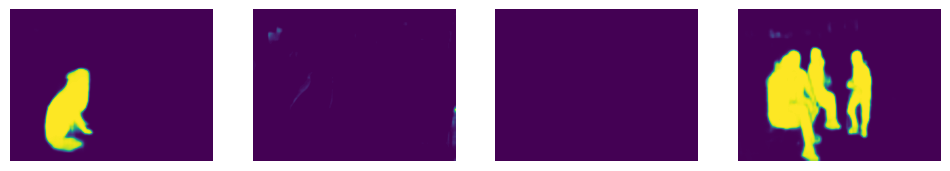

In [23]:

dog_and_person_masks = [
    normalized_masks[img_idx, sem_class_to_idx[cls]]
    for img_idx in range(len(img_list)) for cls in ('dog', 'person')    
]
show(dog_and_person_masks)

In [24]:
for cls in ('dog', 'person'):
    print(sem_class_to_idx[cls])

12
15


In [25]:
class_dim = 1
boolean_dog_masks = (normalized_masks.argmax(dim = class_dim) == sem_class_to_idx['person']) | \
                    (normalized_masks.argmax(dim = class_dim) == sem_class_to_idx['dog'])  
# normalized_masks.shape # torch.Size([2, 21, 576, 768])
# boolean_dog_masks.shape # torch.Size([2, 576, 768])

In [45]:
# torch.full((2, 3), 0.1, dtype = torch.bool)
# torch.ones((3, 4), dtype=torch.bool)
# torch.zeros((2, 3), dtype=torch.bool).float()

tensor([[True, True, True],
        [True, True, True]])

shape = torch.Size([2, 576, 768]), dtype = torch.bool


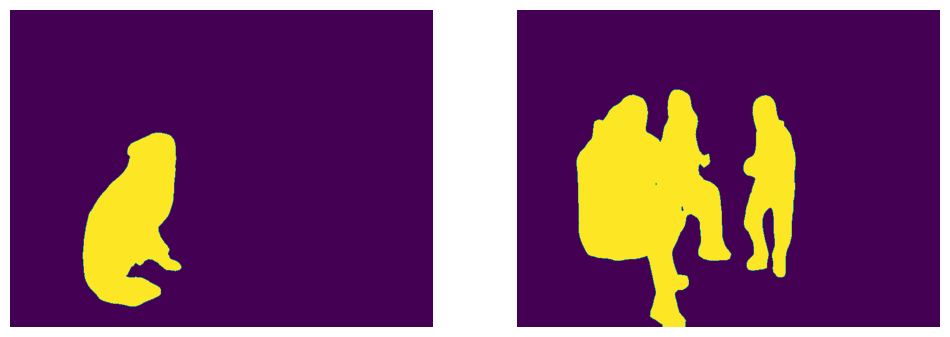

In [46]:
print(f"shape = {boolean_dog_masks.shape}, dtype = {boolean_dog_masks.dtype}")
show([m.float() for m in boolean_dog_masks])

### Segmentation 마스크 

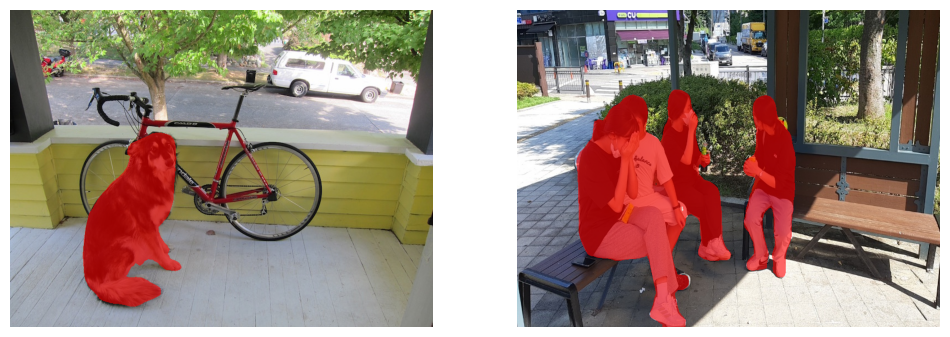

In [47]:
from torchvision.utils import draw_segmentation_masks

dogs_with_masks = [
    draw_segmentation_masks(img, masks=mask, colors= "red", alpha=0.6)
    for img, mask in zip(img_list, boolean_dog_masks)
]
show(dogs_with_masks)